## Tesis de Grado Machine Learning

- Alexis Carrera


## Cargar Base De Datos

## Instalar e importar bibliotecas


In [ ]:
import os
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, RichProgressBar
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pytorch_lightning.loggers import CSVLogger
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

## PARAMETROS

In [178]:
# Configuración
TICKER_DIR = "./data_final_v3"  # Directorio donde están los archivos CSV
LOOKBACK = 60      # Ventana de lookback para las secuencias Reviso 3 meses
PREDICTION_HORIZON = 0  # Predecir 3 meses (60 dias habiles)
BATCH_SIZE = 64
HIDDEN_SIZE = 128
NUM_LAYERS = 3
DROPOUT = 0.3
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1
N_HEAD = 4
NUM_WORKERS = 8
STEP_SIZE = 1

MAXIMA_RENTABILIDAD = 50.0

## Procesamiento de Datos

### Filtro maximo rentabilidad 40 para poder omitir datos muy altos

In [ ]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import os

class StockDataset(Dataset):
    def __init__(self, ticker_files, lookback=60, prediction_horizon=63, step_size=STEP_SIZE):
        """
        Dataset que carga datos bajo demanda para ahorrar RAM

        Args:
            ticker_files: Lista de archivos CSV de tickers
            lookback: Días históricos para cada secuencia
            prediction_horizon: Horizonte de predicción
            step_size: Saltos entre secuencias
        """
        self.lookback = lookback
        self.prediction_horizon = prediction_horizon
        self.step_size = step_size
        self.ticker_files = ticker_files

        # Pre-calcular índices y metadatos sin cargar todos los datos
        self.indices = []  # (ticker_index, start_index) para cada secuencia
        self.scalers = {}
        self.ticker_dfs = {}  # Cache para DataFrames ya cargados
        self.ticker_features = {}  # Cache para features escalados

        self._precompute_indices()

    def _precompute_indices(self):
        """Pre-calcula todos los índices válidos sin cargar datos completos"""
        total_sequences = 0

        for ticker_idx, ticker_file in enumerate(self.ticker_files):
            try:
                # Cargar solo para obtener metadatos
                df = pd.read_csv(ticker_file, nrows=100)  # Solo leer primeras filas para estructura

                if 'Target_3M_Return' not in df.columns:
                    print(f"Saltando {ticker_file}: no tiene Target_3M_Return")
                    continue


                # Leer todo el archivo (una sola vez)
                df = pd.read_csv(ticker_file)
                df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
                df = df.sort_values('Date').reset_index(drop=True)

                total_rows = len(df)

                # Calcular índices válidos para este ticker
                valid_indices = range(
                    self.lookback,
                    total_rows - self.prediction_horizon,
                    self.step_size
                )

                added = 0
                for start_idx in valid_indices:
                    end_idx = start_idx + self.prediction_horizon - 1

                    # Si se sale del rango, romper el bucle
                    if end_idx >= total_rows:
                        break

                    target_value = df['Target_3M_Return'].iloc[end_idx]

                    # Saltar secuencias con target demasiado alto
                    if target_value > MAXIMA_RENTABILIDAD or pd.isna(target_value):
                        continue

                    # Guardar secuencia válida
                    self.indices.append((ticker_idx, start_idx))
                    added += 1

                total_sequences += added

            except Exception as e:
                print(f"Error procesando {ticker_file}: {e}")
                continue

    def _load_ticker_data(self, ticker_idx):
        """Carga y procesa datos de un ticker específico (con cache)"""
        if ticker_idx in self.ticker_dfs:
            return self.ticker_dfs[ticker_idx], self.ticker_features[ticker_idx]

        ticker_file = self.ticker_files[ticker_idx]

        # Cargar DataFrame completo
        df = pd.read_csv(ticker_file)
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.sort_values('Date').reset_index(drop=True)

        # Extraer features
        features = df.drop(['Date', 'Target_Direction', 'Target_3M_Return'],
                          axis=1, errors='ignore')

        # Escalar
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)

        # Guardar en cache
        self.ticker_dfs[ticker_idx] = df
        self.ticker_features[ticker_idx] = features_scaled
        self.scalers[ticker_idx] = scaler

        return df, features_scaled

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        # Obtener metadatos de la secuencia
        ticker_idx, start_idx = self.indices[idx]

        # Cargar datos del ticker (se cachean después de primera carga)
        df, features_scaled = self._load_ticker_data(ticker_idx)

        # Extraer secuencia
        end_idx = start_idx
        start_seq_idx = end_idx - self.lookback

        seq = features_scaled[start_seq_idx:end_idx]
        target = df['Target_3M_Return'].iloc[end_idx + self.prediction_horizon - 1]

        # Convertir a tensores
        seq_tensor = torch.FloatTensor(seq)
        target_tensor = torch.FloatTensor([target])

        return seq_tensor, target_tensor

    def clear_cache(self):
        """Liberar memoria del cache"""
        self.ticker_dfs.clear()
        self.ticker_features.clear()
        self.scalers.clear()


In [ ]:
from torch.utils.data import ConcatDataset, random_split, DataLoader

class StockDataModule(pl.LightningDataModule):



    def __init__(self, ticker_files, lookback=LOOKBACK, prediction_horizon=PREDICTION_HORIZON, batch_size=BATCH_SIZE):
        super().__init__()
        self.ticker_files = self._filter_by_sector(ticker_files)
        self.lookback = lookback
        self.prediction_horizon = prediction_horizon
        self.batch_size = batch_size

    # def _filter_by_sector(self, ticker_files, exclude_sector="Sector_technology"):
    #     """
    #     Filtra los tickers cuyo sector tenga 1 en la columna 'exclude_sector' (por ejemplo 'Sector_technology').

    #     Args:
    #         ticker_files: lista de rutas CSV de tickers
    #         exclude_sector: nombre de la columna de sector a excluir (ej. 'Sector_technology')
    #     """
    #     filtered = []
    #     for f in ticker_files:
    #         if  f == "./data_final_v3/GOOGL_completo_arreglado.csv" or f == "./data_final_v3/GOOG_completo_arreglado.csv" or f == "./data_final_v3/AMZN_completo_arreglado.csv" or f == "./data_final_v3/META_completo_arreglado.csv" or f == "./data_final_v3/TSLA_completo_arreglado.csv":
    #           continue # excluir si pertenece a las big 5 ademas de technology
    #         try:
    #             df = pd.read_csv(f, nrows=1)  # leer solo la primera fila para detectar el sector
    #             if exclude_sector in df.columns:
    #                 # Tomar el valor de la primera fila en esa columna
    #                 sector_flag = df[exclude_sector].iloc[0]
    #                 if sector_flag == 1:
    #                     continue  # excluir si pertenece a ese sector
    #             filtered.append(f)
    #         except Exception as e:
    #             print(f"⚠️ Error leyendo {f}: {e}")
    #             continue

    #     print(f"✅ Tickers incluidos tras filtro de sector (excluyendo {exclude_sector}): {len(filtered)}")
    #     return filtered


    def _filter_by_sector(self, ticker_files):
        """
        Filtra los tickers cuyo sector tenga 1 en la columna 'exclude_sector' (por ejemplo 'Sector_technology').

        Args:
            ticker_files: lista de rutas CSV de tickers
            exclude_sector: nombre de la columna de sector a excluir (ej. 'Sector_technology')
        """
        filtered = []
        for f in ticker_files:
            if  f == "./data_final_v3/GOOGL_completo_arreglado.csv" or f == "./data_final_v3/GOOG_completo_arreglado.csv" or f == "./data_final_v3/AMZN_completo_arreglado.csv" or f == "./data_final_v3/META_completo_arreglado.csv" or f == "./data_final_v3/TSLA_completo_arreglado.csv":
              continue # excluir si pertenece a las big 5 ademas de technology
            try:
                df = pd.read_csv(f, nrows=1)  # leer solo la primera fila para detectar el sector
                if 'Sector_consumer-defensive' in df.columns:
                    # Tomar el valor de la primera fila en esa columna
                    sector_flag = df['Sector_consumer-defensive'].iloc[0]
                    if sector_flag != 1:
                        continue  # excluir si pertenece a ese sector
                filtered.append(f)
            except Exception as e:
                print(f"⚠️ Error leyendo {f}: {e}")
                continue

        print(f"✅ Tickers incluidos tras filtro de sector (solo Sector_consumer-defensive): {len(filtered)}")
        return filtered

    def setup(self, stage=None):
        train_datasets = []
        val_datasets = []
        test_datasets = []

        for file in self.ticker_files:
            # Dataset de un solo ticker
            dataset = StockDataset([file], self.lookback, self.prediction_horizon)
            n = len(dataset)
            if n < 3:
                continue  # evita errores con series demasiado cortas

            train_size = int(n * TRAIN_RATIO)
            val_size = int(n * VAL_RATIO)
            test_size = n - train_size - val_size

            train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
            train_datasets.append(train_ds)
            val_datasets.append(val_ds)
            test_datasets.append(test_ds)

        # Combinar pero manteniendo independencia por ticker
        self.train_dataset = ConcatDataset(train_datasets)
        self.val_dataset = ConcatDataset(val_datasets)
        self.test_dataset = ConcatDataset(test_datasets)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=NUM_WORKERS)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=NUM_WORKERS)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=NUM_WORKERS)


In [181]:
# Modelo LSTM
class StockLSTM(pl.LightningModule):
    def __init__(self, input_size, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS,
                 dropout=DROPOUT, learning_rate=LEARNING_RATE):
        super().__init__()
        self.save_hyperparameters()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.learning_rate = learning_rate

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Inicializar estados oculto y de celda
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Pasar por LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Tomar la última salida de la secuencia
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc(out)
        return out

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('train_loss', loss)
        mae = torch.abs(y_hat - y).mean()
        rmse = torch.sqrt(loss)
        self.log('train_mae', mae,on_epoch=True, on_step=False)
        self.log('train_rmse', rmse,on_epoch=True, on_step=False)
        return rmse

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('val_loss', loss,  on_epoch=True)
        mae = torch.abs(y_hat - y).mean()
        rmse = torch.sqrt(loss)
        self.log('val_mae', mae,  on_epoch=True, on_step=False, prog_bar=True)
        self.log('val_rmse', rmse,  on_epoch=True, on_step=False, prog_bar=True)
        return rmse

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('test_loss', loss)
        mae = torch.abs(y_hat - y).mean()
        rmse = torch.sqrt(loss)
        self.log('test_mae', mae, on_epoch=True, on_step=False)
        self.log('test_rmse', rmse, on_epoch=True, on_step=False)
        return rmse


In [182]:
# Modelo GRU
class StockGRU(pl.LightningModule):
    def __init__(self, input_size, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS,
                 dropout=DROPOUT, learning_rate=LEARNING_RATE):
        super().__init__()
        self.save_hyperparameters()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.learning_rate = learning_rate

        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Inicializar estado oculto
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Pasar por GRU
        out, _ = self.gru(x, h0)

        # Tomar la última salida de la secuencia
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc(out)
        return out

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('train_loss', loss)
        mae = torch.abs(y_hat - y).mean()
        rmse = torch.sqrt(loss)
        self.log('train_mae', mae,on_epoch=True, on_step=False)
        self.log('train_rmse', rmse,on_epoch=True, on_step=False)
        return rmse

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('val_loss', loss,  on_epoch=True)
        mae = torch.abs(y_hat - y).mean()
        rmse = torch.sqrt(loss)
        self.log('val_mae', mae,  on_epoch=True, on_step=False, prog_bar=True)
        self.log('val_rmse', rmse,  on_epoch=True, on_step=False, prog_bar=True)
        return rmse

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('test_loss', loss)
        mae = torch.abs(y_hat - y).mean()
        rmse = torch.sqrt(loss)
        self.log('test_mae', mae, on_epoch=True, on_step=False)
        self.log('test_rmse', rmse, on_epoch=True, on_step=False)
        return rmse

In [183]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import math

class GatedResidualNetwork(nn.Module):
    """Red Residual con Mecanismo de Compuerta (GRN)"""
    def __init__(self, input_size, hidden_size, output_size, dropout=0.1, context_size=None):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.dropout = dropout

        # Capa para proyecto a espacio intermedio
        self.fc1 = nn.Linear(input_size, hidden_size)

        # Capa para contexto si se proporciona
        if context_size is not None:
            self.context_proj = nn.Linear(context_size, hidden_size, bias=False)

        # Capa de activación y dropout
        self.activation = nn.ELU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.dropout_layer = nn.Dropout(dropout)

        # Compuerta y normalización
        self.gate = nn.Linear(output_size, output_size)
        self.layer_norm = nn.LayerNorm(output_size)

        # Proyección residual si las dimensiones no coinciden
        self.residual_proj = None
        if input_size != output_size:
            self.residual_proj = nn.Linear(input_size, output_size)

    def forward(self, x, context=None):
        # Proyección principal
        output = self.fc1(x)

        # Añadir contexto si está disponible
        if context is not None:
            context_proj = self.context_proj(context)
            output = output + context_proj

        output = self.activation(output)
        output = self.fc2(output)
        output = self.dropout_layer(output)

        # Mecanismo de compuerta
        gate = torch.sigmoid(self.gate(output))

        # Conexión residual
        residual = self.residual_proj(x) if self.residual_proj is not None else x
        output = gate * output + (1 - gate) * residual

        return self.layer_norm(output)

class VariableSelectionNetwork(nn.Module):
    """Red de Selección de Variables"""
    def __init__(self, input_sizes, hidden_size, dropout=0.1):
        super().__init__()
        self.input_sizes = input_sizes
        self.hidden_size = hidden_size

        # GRNs individuales para cada variable
        self.grn_list = nn.ModuleList([
            GatedResidualNetwork(input_size, hidden_size, hidden_size, dropout)
            for input_size in input_sizes
        ])

        # GRN para pesos de atención
        self.weight_grn = GatedResidualNetwork(
            hidden_size * len(input_sizes),
            hidden_size,
            len(input_sizes),
            dropout
        )

    def forward(self, variables):
        # Procesar cada variable individualmente
        processed_vars = []
        for i, var in enumerate(variables):
            processed_vars.append(self.grn_list[i](var))

        # Concatenar todas las variables procesadas
        concatenated = torch.cat(processed_vars, dim=-1)

        # Calcular pesos de atención
        weights = self.weight_grn(concatenated)
        weights = F.softmax(weights, dim=-1)

        # Aplicar pesos y combinar
        weighted_vars = []
        for i, var in enumerate(processed_vars):
            weight = weights[:, :, i:i+1] if len(weights.shape) == 3 else weights[:, i:i+1]
            weighted_vars.append(var * weight)

        return torch.sum(torch.stack(weighted_vars, dim=-1), dim=-1), weights

class InterpretableMultiHeadAttention(nn.Module):
    """Atención Multi-Head Interpretable (como en el paper TFT)"""
    def __init__(self, hidden_size, n_heads, dropout=0.1):
        super().__init__()
        self.hidden_size = hidden_size
        self.n_heads = n_heads
        self.head_size = hidden_size // n_heads

        # Proyecciones Q, K, V
        self.q_proj = nn.Linear(hidden_size, hidden_size)
        self.k_proj = nn.Linear(hidden_size, hidden_size)
        self.v_proj = nn.Linear(hidden_size, hidden_size)

        # Capa de salida
        self.output_proj = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
        batch_size, seq_len, _ = query.shape

        # Proyectar Q, K, V
        Q = self.q_proj(query).view(batch_size, seq_len, self.n_heads, self.head_size)
        K = self.k_proj(key).view(batch_size, seq_len, self.n_heads, self.head_size)
        V = self.v_proj(value).view(batch_size, seq_len, self.n_heads, self.head_size)

        # Transponer para atención
        Q = Q.transpose(1, 2)  # (batch, heads, seq_len, head_size)
        K = K.transpose(1, 2)
        V = V.transpose(1, 2)

        # Calcular scores de atención
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_size)

        # Aplicar máscara si existe
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        # Softmax y dropout
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Aplicar atención
        attn_output = torch.matmul(attn_weights, V)

        # Transponer de vuelta y combinar heads
        attn_output = attn_output.transpose(1, 2).contiguous().view(
            batch_size, seq_len, self.hidden_size
        )

        # Proyección final
        output = self.output_proj(attn_output)

        return output, attn_weights

class TemporalFusionTransformer(pl.LightningModule):
    """
    Temporal Fusion Transformer para predicción de precios de bolsa
    Implementación inspirada en el paper original
    """
    def __init__(self,
                 input_size=5,  # típico: [Open, High, Low, Close, Volume]
                #  hidden_size=128,
                 hidden_size=256,
                #  num_layers=2,
                 num_layers=4,
                 dropout=0.1,
                 learning_rate=1e-3,
                #  n_heads=4,
                 n_heads=8,
                 future_steps=1):  # Predicción de un solo valor

        super().__init__()
        self.save_hyperparameters()

        # Hiperparámetros
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lr = learning_rate
        self.n_heads = n_heads
        self.future_steps = future_steps

        # Asumimos que todas las características tienen el mismo tamaño
        # En una implementación más compleja, podrías separar variables estáticas vs temporales
        input_sizes = [input_size]  # Solo variables temporales

        # Red de selección de variables temporal
        self.temporal_vsn = VariableSelectionNetwork(
            input_sizes, hidden_size, dropout
        )

        # Codificación de posición
        self.position_encoding = PositionalEncoding(hidden_size, dropout)

        # LSTM encoder
        self.lstm_encoder = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=False
        )

        # Atención temporal
        self.temporal_attention = InterpretableMultiHeadAttention(
            hidden_size, n_heads, dropout
        )

        # Capas de transformación
        self.grn_attention = GatedResidualNetwork(
            hidden_size, hidden_size, hidden_size, dropout
        )

        self.grn_final = GatedResidualNetwork(
            hidden_size, hidden_size, hidden_size, dropout
        )

        # Capa de salida
        self.output_layer = nn.Linear(hidden_size, future_steps)

        # Normalizaciones
        self.layer_norm_attn = nn.LayerNorm(hidden_size)
        self.layer_norm_final = nn.LayerNorm(hidden_size)

        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, x):
        """
        x: (batch, lookback, n_features)
        returns: (batch, future_steps)
        """
        batch_size, lookback, n_features = x.shape

        # Selección de variables temporales
        temporal_vars = [x]  # En este caso simplificado, solo tenemos variables temporales

        temporal_selected, temporal_weights = self.temporal_vsn(temporal_vars)

        # Codificación de posición
        temporal_encoded = self.position_encoding(temporal_selected)

        # Procesamiento LSTM
        lstm_out, (hidden, cell) = self.lstm_encoder(temporal_encoded)

        # Atención temporal
        attn_out, attn_weights = self.temporal_attention(
            lstm_out, lstm_out, lstm_out
        )

        # Residual + Normalización después de atención
        attn_residual = self.layer_norm_attn(lstm_out + self.dropout_layer(attn_out))

        # GRN después de atención
        grn_attn_out = self.grn_attention(attn_residual)

        # Tomar la última posición temporal (más reciente)
        last_timestep = grn_attn_out[:, -1, :]

        # Transformación final
        final_output = self.grn_final(last_timestep)
        final_output = self.layer_norm_final(final_output)

        # Salida
        output = self.output_layer(final_output)

        return output

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=10, verbose=True
        )

        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',
                'frequency': 1
            }
        }

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        # Asegurarnos de que las dimensiones coincidan
        if y_hat.shape != y.shape:
            y = y.view_as(y_hat)

        loss = F.mse_loss(y_hat, y)
        mae = F.l1_loss(y_hat, y)

        rmse = torch.sqrt(loss)

        self.log('train_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log('train_mae', mae, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train_rmse', mae, prog_bar=True, on_step=False, on_epoch=True)

        return rmse


    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        if y_hat.shape != y.shape:
            y = y.view_as(y_hat)

        loss = F.mse_loss(y_hat, y)
        mae = F.l1_loss(y_hat, y)

        rmse = torch.sqrt(loss)

        self.log('val_loss', loss, prog_bar=True, on_epoch=True)
        self.log('val_mae', mae, prog_bar=True, on_epoch=True)
        self.log('val_rmse', mae, prog_bar=True, on_epoch=True)

        return rmse

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        if y_hat.shape != y.shape:
            y = y.view_as(y_hat)

        loss = F.mse_loss(y_hat, y)
        mae = F.l1_loss(y_hat, y)

        rmse = torch.sqrt(loss)

        self.log('test_loss', loss, on_epoch=True)
        self.log('test_mae', mae, on_epoch=True)
        self.log('test_rmse', mae, on_epoch=True)

        return rmse

class PositionalEncoding(nn.Module):
    """Codificación posicional para secuencias temporales"""
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(1), :].transpose(0, 1)
        return self.dropout(x)



In [ ]:
StockTFT = TemporalFusionTransformer

In [185]:
# Obtener lista de archivos
ticker_files = [os.path.join(TICKER_DIR, f) for f in os.listdir(TICKER_DIR)
                if f.endswith('_completo_arreglado.csv')]

In [186]:
ticker_files

['./data_final_v3/GOOGL_completo_arreglado.csv',
 './data_final_v3/RL_completo_arreglado.csv',
 './data_final_v3/CSCO_completo_arreglado.csv',
 './data_final_v3/IPG_completo_arreglado.csv',
 './data_final_v3/UAL_completo_arreglado.csv',
 './data_final_v3/EMR_completo_arreglado.csv',
 './data_final_v3/ROST_completo_arreglado.csv',
 './data_final_v3/AES_completo_arreglado.csv',
 './data_final_v3/HD_completo_arreglado.csv',
 './data_final_v3/ZTS_completo_arreglado.csv',
 './data_final_v3/NXPI_completo_arreglado.csv',
 './data_final_v3/BX_completo_arreglado.csv',
 './data_final_v3/XYZ_completo_arreglado.csv',
 './data_final_v3/DG_completo_arreglado.csv',
 './data_final_v3/FI_completo_arreglado.csv',
 './data_final_v3/KMI_completo_arreglado.csv',
 './data_final_v3/AXON_completo_arreglado.csv',
 './data_final_v3/TJX_completo_arreglado.csv',
 './data_final_v3/GS_completo_arreglado.csv',
 './data_final_v3/PSX_completo_arreglado.csv',
 './data_final_v3/MKC_completo_arreglado.csv',
 './data_fina

In [187]:
tickers_financial = ticker_files

In [188]:
len(tickers_financial)

503

In [189]:
ticker_files = tickers_financial

In [190]:
import pandas as pd
minimo = 80
ticker_data = ""
for ticker_file in ticker_files:  # Revisa los primeros 5 archivos
    df = pd.read_csv(ticker_file)
    if minimo < df.columns.shape[0]:
        # print(f"Archivo: {ticker_file}, Columnas: {df.columns.shape}, Forma: {df.shape}")
        minimo = df.columns.shape[0]
        # print(f"Archivo: {ticker_file}, Columnas: {df.columns.shape}, Forma: {df.shape}")
        ticker_data = ticker_file
print(minimo)
print(ticker_data)

99
./data_final_v3/GOOGL_completo_arreglado.csv


In [191]:
ticker_files[0]

'./data_final_v3/GOOGL_completo_arreglado.csv'

In [192]:
print(f"Encontrados {len(ticker_files)} archivos de tickers")

# Crear módulo de datos
data_module = StockDataModule(ticker_files)
data_module.setup()

print(f"Número de secuencias de entrenamiento: {len(data_module.train_dataset)}")
print(f"Número de secuencias de validación: {len(data_module.val_dataset)}")
print(f"Número de secuencias de prueba: {len(data_module.test_dataset)}")

Encontrados 503 archivos de tickers
✅ Tickers incluidos tras filtro de sector (solo Sector_consumer-defensive): 37
Número de secuencias de entrenamiento: 22742
Número de secuencias de validación: 2833
Número de secuencias de prueba: 2863


In [193]:
# Modelo
input_size = data_module.train_dataset[0][0].shape[1]  # Número de características
input_size

96

In [194]:
data_module.train_dataset[0]

(tensor([[-0.4816, -0.4837, -0.5051,  ...,  0.0000,  0.0000,  0.0000],
         [-0.5035, -0.4939, -0.5059,  ...,  0.0000,  0.0000,  0.0000],
         [-0.5139, -0.4959, -0.5056,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [-0.2003, -0.1516, -0.1695,  ...,  0.0000,  0.0000,  0.0000],
         [-0.2287, -0.1675, -0.1782,  ...,  0.0000,  0.0000,  0.0000],
         [-0.2630, -0.1914, -0.1859,  ...,  0.0000,  0.0000,  0.0000]]),
 tensor([-11.7321]))

In [195]:
# Inicialización del modulo lightning
lstm_model = StockLSTM(input_size=input_size, learning_rate= LEARNING_RATE)

callback_check = ModelCheckpoint(save_top_k=1, mode="min", monitor="val_rmse") # guardamos el mejor modelo monitoreado en la acc de validación. Por qué no la de entrenamiento?

callback_tqdm = RichProgressBar(leave=True)

early_stopping = EarlyStopping(monitor='val_rmse', patience=10, mode='min')

logger = CSVLogger(save_dir="logs/", name="lstm-proyecto-final")

In [196]:
trainer = pl.Trainer(max_epochs=NUM_EPOCHS,
                    callbacks=[early_stopping, callback_check, callback_tqdm],
                    accelerator="auto",  # Uses GPUs or TPUs if available
                    devices="auto",  # Uses all available GPUs/TPUs if applicable
                    logger=logger,
                    deterministic=False,
                    log_every_n_steps=10)

INFO:pytorch_lightning.utilities.rank_zero:Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [197]:
start_time = time.time()
trainer.fit(model = lstm_model, datamodule = data_module)

runtime = (time.time() - start_time) / 60
print(f"Tiempo de entrenamiento en minutos: {runtime:.2f}")

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


┏━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type    ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ lstm    │ LSTM    │  379 K │ train │
│ 1 │ fc      │ Linear  │    129 │ train │
│ 2 │ dropout │ Dropout │      0 │ train │
└───┴─────────┴─────────┴────────┴───────┘

Trainable params: 380 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 380 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 3                                                                                           
Modules in eval mode: 0

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Tiempo de entrenamiento en minutos: 13.90


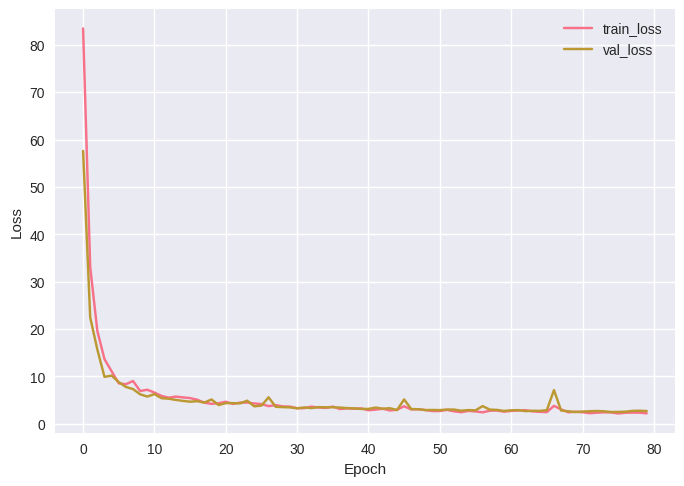

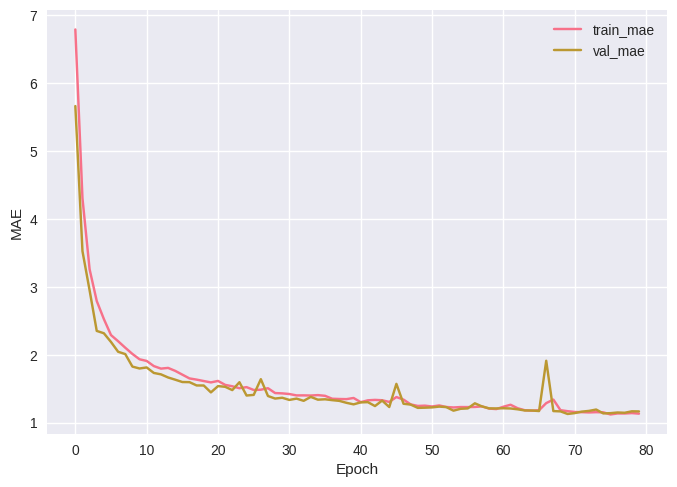

In [198]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "val_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)
df_metrics[["train_mae", "val_mae"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="MAE"
)

plt.show()

In [199]:
# Evaluación
trainer.test(model = lstm_model, datamodule = data_module, ckpt_path = 'best')

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at logs/lstm-proyecto-final/version_3/checkpoints/epoch=69-step=24920.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at logs/lstm-proyecto-final/version_3/checkpoints/epoch=69-step=24920.ckpt


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    1.4971634149551392     │
│         test_mae          │    0.8900295495986938     │
│         test_rmse         │    1.1862492561340332     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.4971634149551392,
  'test_mae': 0.8900295495986938,
  'test_rmse': 1.1862492561340332}]

In [200]:
# Inicialización del modulo lightning
gru_model = StockGRU(input_size=input_size, learning_rate= LEARNING_RATE)

callback_check = ModelCheckpoint(save_top_k=1, mode="min", monitor="val_rmse") # guardamos el mejor modelo monitoreado en la acc de validación. Por qué no la de entrenamiento?

callback_tqdm = RichProgressBar(leave=True)

early_stopping = EarlyStopping(monitor='val_rmse', patience=10, mode='min')

logger = CSVLogger(save_dir="logs/", name="gru-proyecto-final")

In [201]:
trainer = pl.Trainer(max_epochs=NUM_EPOCHS,
                    callbacks=[early_stopping, callback_check, callback_tqdm],
                    accelerator="auto",  # Uses GPUs or TPUs if available
                    devices="auto",  # Uses all available GPUs/TPUs if applicable
                    logger=logger,
                    deterministic=False,
                    log_every_n_steps=10)

INFO:pytorch_lightning.utilities.rank_zero:Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [202]:
start_time = time.time()
trainer.fit(model = gru_model, datamodule = data_module)

runtime = (time.time() - start_time) / 60
print(f"Tiempo de entrenamiento en minutos: {runtime:.2f}")

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


┏━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type    ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ gru     │ GRU     │  284 K │ train │
│ 1 │ fc      │ Linear  │    129 │ train │
│ 2 │ dropout │ Dropout │      0 │ train │
└───┴─────────┴─────────┴────────┴───────┘

Trainable params: 285 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 285 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 3                                                                                           
Modules in eval mode: 0

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Tiempo de entrenamiento en minutos: 9.68


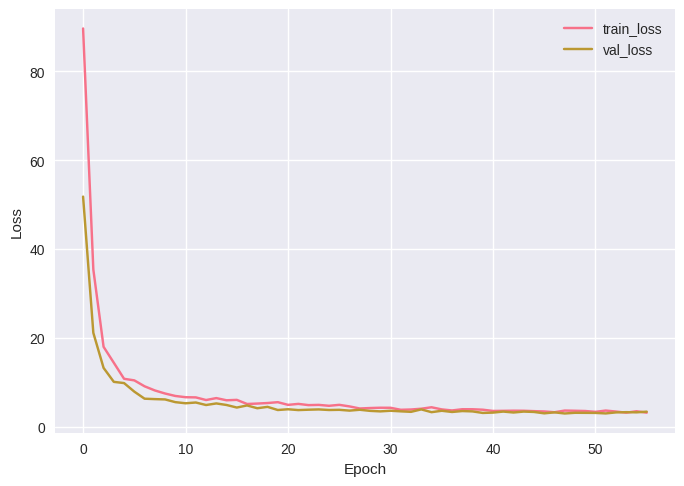

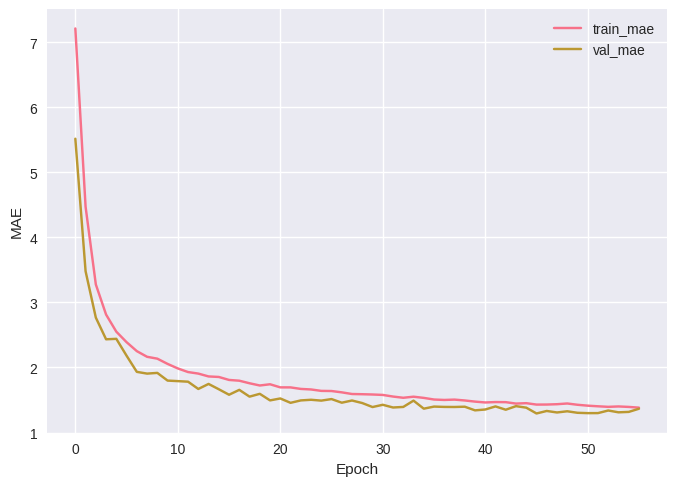

In [203]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "val_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)
df_metrics[["train_mae", "val_mae"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="MAE"
)

plt.show()

In [204]:
# Evaluación
trainer.test(model = gru_model, datamodule = data_module, ckpt_path = 'best')

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at logs/gru-proyecto-final/version_2/checkpoints/epoch=45-step=16376.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at logs/gru-proyecto-final/version_2/checkpoints/epoch=45-step=16376.ckpt


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    2.0802528858184814     │
│         test_mae          │    1.0898839235305786     │
│         test_rmse         │    1.4156036376953125     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 2.0802528858184814,
  'test_mae': 1.0898839235305786,
  'test_rmse': 1.4156036376953125}]

# **TFT**

In [ ]:
tft_model = StockTFT(input_size=input_size, learning_rate= LEARNING_RATE)

callback_check = ModelCheckpoint(save_top_k=1, mode="min", monitor="val_rmse") # guardamos el mejor modelo monitoreado en la acc de validación. Por qué no la de entrenamiento?

callback_tqdm = RichProgressBar(leave=True)

early_stopping = EarlyStopping(monitor='val_rmse', patience=10, mode='min')

logger = CSVLogger(save_dir="logs/", name="tft-proyecto-final")

In [293]:
trainer = pl.Trainer(max_epochs=NUM_EPOCHS,
                    callbacks=[early_stopping, callback_check, callback_tqdm],
                    accelerator="auto",  # Uses GPUs or TPUs if available
                    devices="auto",  # Uses all available GPUs/TPUs if applicable
                    logger=logger,
                    deterministic=False,
                    log_every_n_steps=10)

INFO:pytorch_lightning.utilities.rank_zero:Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [294]:
start_time = time.time()
trainer.fit(model = tft_model, datamodule = data_module)

runtime = (time.time() - start_time) / 60
print(f"Tiempo de entrenamiento en minutos: {runtime:.2f}")

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


┏━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name               ┃ Type                            ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ temporal_vsn       │ VariableSelectionNetwork        │  248 K │ train │
│ 1 │ position_encoding  │ PositionalEncoding              │      0 │ train │
│ 2 │ lstm_encoder       │ LSTM                            │  2.1 M │ train │
│ 3 │ temporal_attention │ InterpretableMultiHeadAttention │  263 K │ train │
│ 4 │ grn_attention      │ GatedResidualNetwork            │  197 K │ train │
│ 5 │ grn_final          │ GatedResidualNetwork            │  197 K │ train │
│ 6 │ output_layer       │ Linear                          │    257 │ train │
│ 7 │ layer_norm_attn    │ LayerNorm                       │    512 │ train │
│ 8 │ layer_norm_final   │ LayerNorm                       │    512 │ train │
│ 9 │ dropout_layer      │ Dropout                         │      0 │ train │
└───┴────────────────────┴─────────────────────────────────┴────────┴───────┘

Trainable params: 3.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.0 M                                                                                                
Total estimated model params size (MB): 12                                                                         
Modules in train mode: 45                                                                                          
Modules in eval mode: 0

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Tiempo de entrenamiento en minutos: 31.46


# MODELO 8 heads

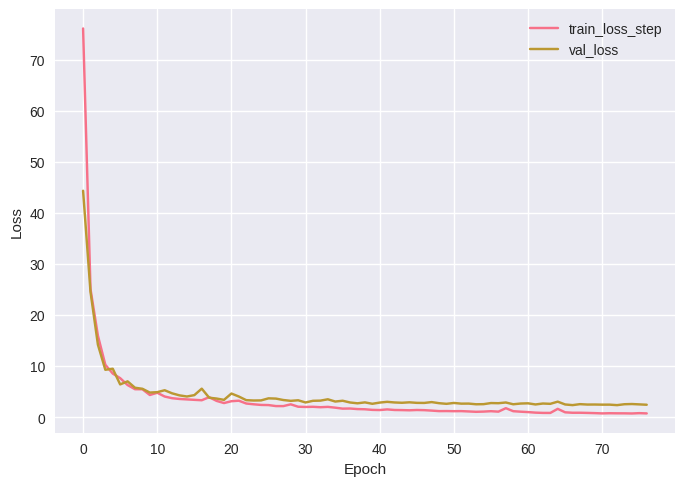

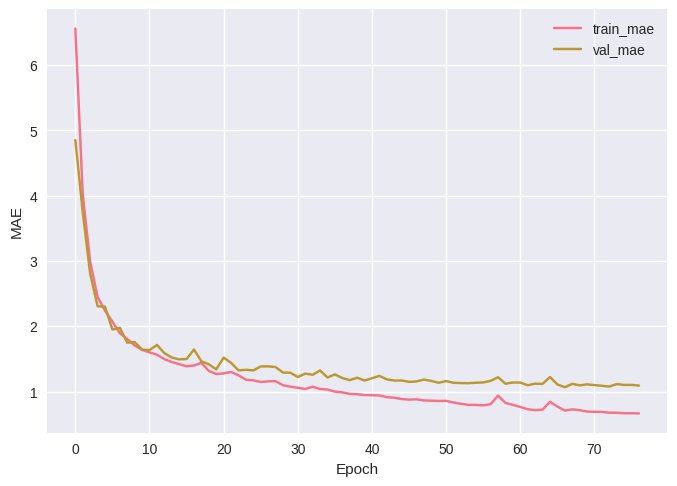

In [295]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss_step", "val_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)
df_metrics[["train_mae", "val_mae"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="MAE"
)

plt.show()

# MODELO ANTERIOR N heads 4

In [296]:
trainer.test(model = tft_model, datamodule = data_module, ckpt_path = 'best')

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at logs/tft-proyecto-final/version_4/checkpoints/epoch=66-step=23852.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at logs/tft-proyecto-final/version_4/checkpoints/epoch=66-step=23852.ckpt


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.8297479152679443     │
│         test_mae          │    0.6355035305023193     │
│         test_rmse         │    0.6355035305023193     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.8297479152679443,
  'test_mae': 0.6355035305023193,
  'test_rmse': 0.6355035305023193}]

## Predicción

In [297]:
def get_predictions_with_actuals(model, dataloader):
    device = next(model.parameters()).device  # obtiene el dispositivo del modelo
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for batch in dataloader:
            # Asegúrate de mover los tensores al mismo device
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            predictions.append(outputs.cpu())  # devuelves a CPU para concatenar
            actuals.append(targets.cpu())

    return torch.cat(predictions).numpy(), torch.cat(actuals).numpy()


## LSTM EVALUACIÓN

In [212]:
# import pytorch_lightning as pl

# # Ruta del checkpoint
# checkpoint_path = "./logs/lstm-proyecto-final/version_6/checkpoints/epoch=61-step=148366.ckpt"

# # Cargar el modelo con los pesos
# lstm_model = StockLSTM.load_from_checkpoint(checkpoint_path)

# lstm_model.eval()  # Modo evaluación

In [298]:
# Obtener el dataloader de test
test_dataloader = data_module.test_dataloader()

# Obtener predicciones y valores reales
predicted, actual = get_predictions_with_actuals(lstm_model, test_dataloader)

print(predicted)
print(actual)

# Calcular métricas de error
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))
epsilon = 1e-8
mape = np.mean(np.abs((actual - predicted) / (actual + epsilon))) * 100

print(f"MAE: {mae:.2f}%")
print(f"RMSE: {rmse:.2f}%")
print(f"MAPE: {mape:.2f}%")

[[ 12.435438 ]
 [-10.627983 ]
 [  2.3364258]
 ...
 [ 13.4019985]
 [ -5.8277273]
 [-13.279292 ]]
[[ 12.796991]
 [ -9.652367]
 [  2.003331]
 ...
 [ 13.070614]
 [ -6.275566]
 [-12.943739]]
MAE: 0.87%
RMSE: 1.19%
MAPE: 128.08%


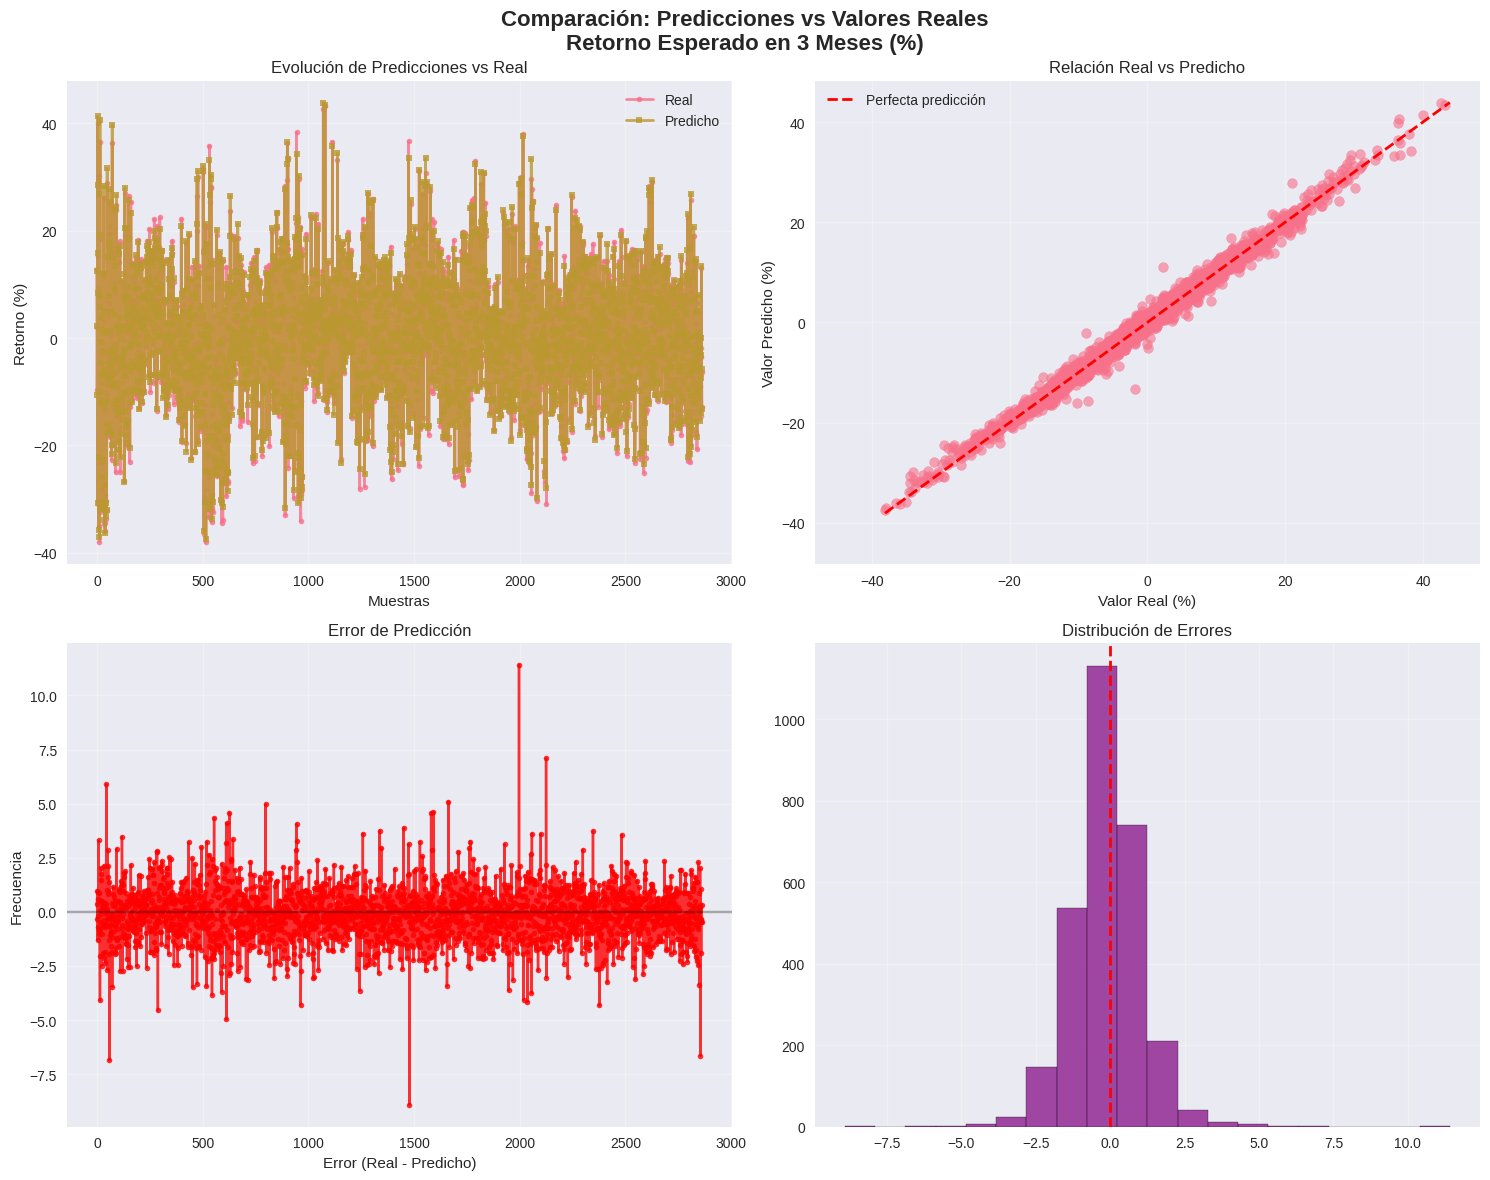

In [299]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Configurar estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Crear figura
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Comparación: Predicciones vs Valores Reales\nRetorno Esperado en 3 Meses (%)',
             fontsize=16, fontweight='bold')

# 1. Gráfico de líneas comparativo
axes[0, 0].plot(actual, label='Real', marker='o', markersize=4, linewidth=2, alpha=0.8)
axes[0, 0].plot(predicted, label='Predicho', marker='s', markersize=4, linewidth=2, alpha=0.8)
axes[0, 0].set_xlabel('Muestras')
axes[0, 0].set_ylabel('Retorno (%)')
axes[0, 0].set_title('Evolución de Predicciones vs Real')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Scatter plot con línea de perfecta predicción
max_val = max(max(predicted), max(actual))
min_val = min(min(predicted), min(actual))
limit = max(abs(max_val), abs(min_val)) * 1.1

axes[0, 1].scatter(actual, predicted, alpha=0.6, s=50)
axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfecta predicción')
axes[0, 1].set_xlabel('Valor Real (%)')
axes[0, 1].set_ylabel('Valor Predicho (%)')
axes[0, 1].set_title('Relación Real vs Predicho')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlim(-limit, limit)
axes[0, 1].set_ylim(-limit, limit)

# 3. Gráfico de error (diferencia)
error = np.array(actual) - np.array(predicted)
axes[1, 0].plot(error, marker='o', markersize=4, color='red', alpha=0.8)
axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[1, 0].set_xlabel('Muestras')
axes[1, 0].set_ylabel('Error (Real - Predicho)')
axes[1, 0].set_title('Error de Predicción')
axes[1, 0].grid(True, alpha=0.3)

# 4. Histograma de errores
axes[1, 1].hist(error, bins=20, alpha=0.7, color='purple', edgecolor='black')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Error (Real - Predicho)')
axes[1, 0].set_ylabel('Frecuencia')
axes[1, 1].set_title('Distribución de Errores')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## GRU EVALUACIÓN

In [215]:
# import pytorch_lightning as pl

# # Ruta del checkpoint
# checkpoint_path = "./logs/gru-proyecto-final/version_6/checkpoints/epoch=31-step=76576.ckpt"

# # Cargar el modelo con los pesos
# gru_model = StockGRU.load_from_checkpoint(checkpoint_path)

# gru_model.eval()  # Modo evaluación

In [300]:
# Obtener el dataloader de test
test_dataloader = data_module.test_dataloader()

# Obtener predicciones y valores reales
predicted, actual = get_predictions_with_actuals(gru_model, test_dataloader)

print(predicted)
print(actual)

# Calcular métricas de error
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))
epsilon = 1e-8
mape = np.mean(np.abs((actual - predicted) / (actual + epsilon))) * 100

print(f"MAE: {mae:.2f}%")
print(f"RMSE: {rmse:.2f}%")
print(f"MAPE: {mape:.2f}%")

[[ 13.902653]
 [-10.904251]
 [  3.228348]
 ...
 [ 11.820557]
 [ -5.098901]
 [-13.896357]]
[[ 12.796991]
 [ -9.652367]
 [  2.003331]
 ...
 [ 13.070614]
 [ -6.275566]
 [-12.943739]]
MAE: 1.08%
RMSE: 1.43%
MAPE: 211.35%


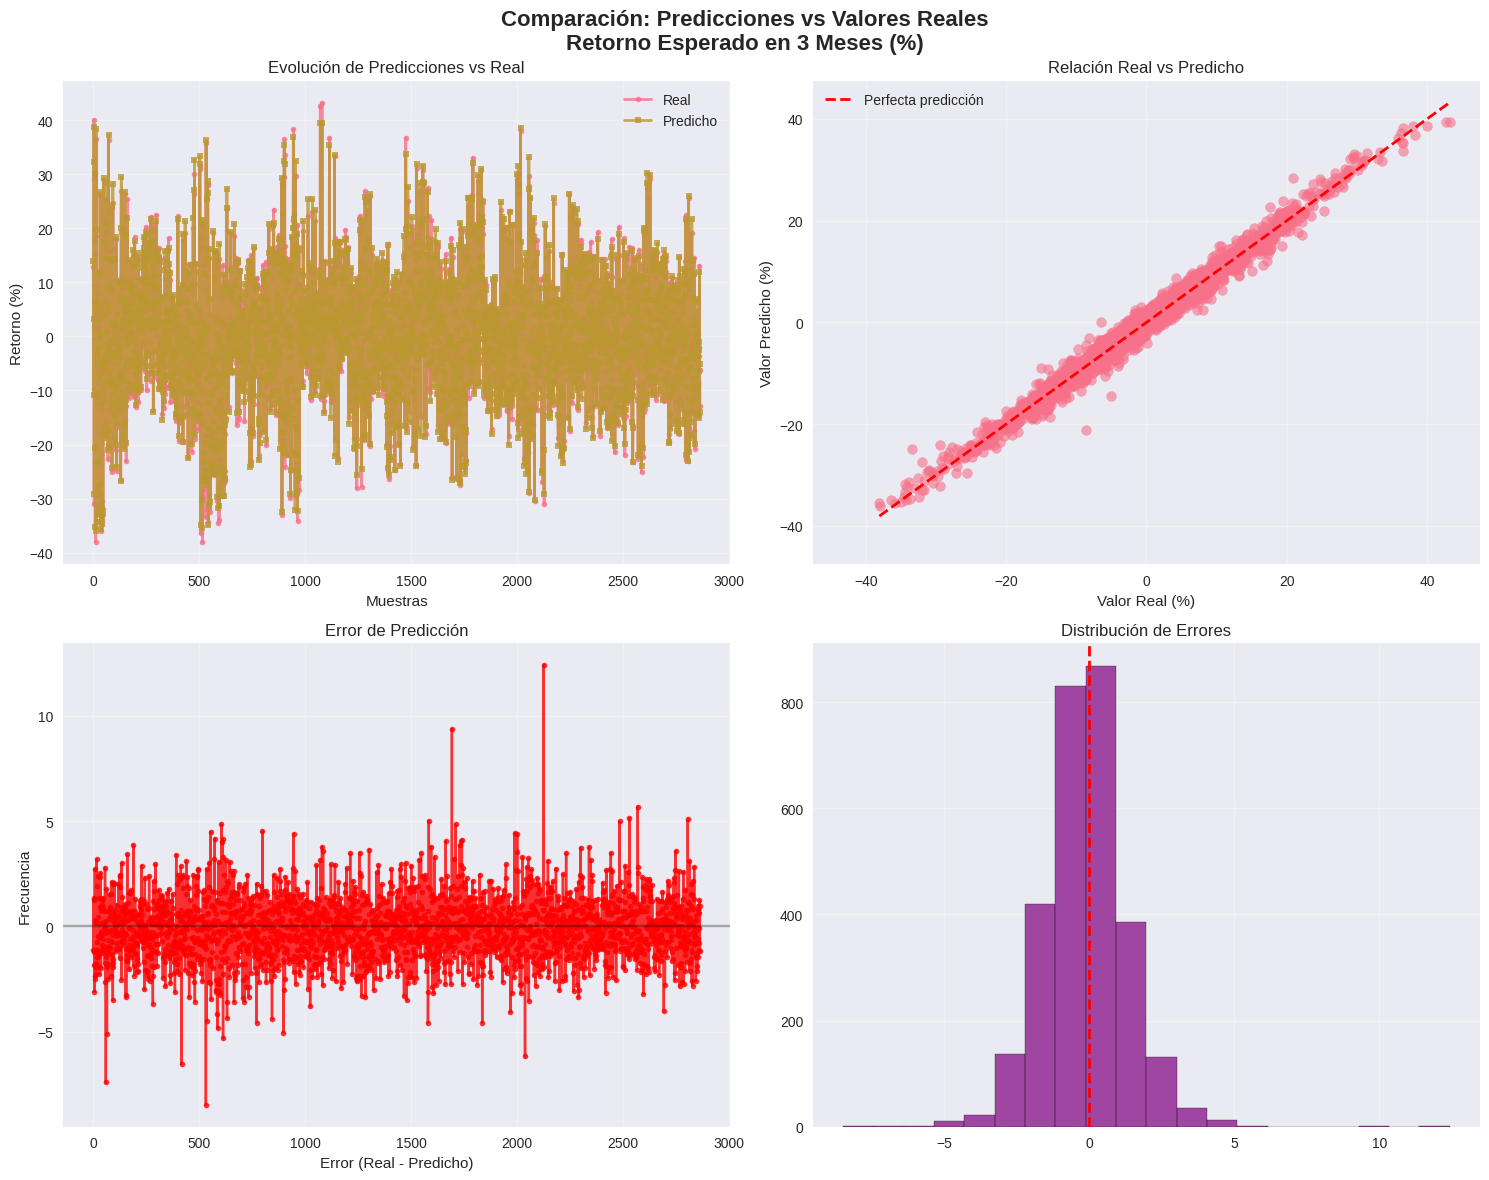

In [301]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Configurar estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Crear figura
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Comparación: Predicciones vs Valores Reales\nRetorno Esperado en 3 Meses (%)',
             fontsize=16, fontweight='bold')

# 1. Gráfico de líneas comparativo
axes[0, 0].plot(actual, label='Real', marker='o', markersize=4, linewidth=2, alpha=0.8)
axes[0, 0].plot(predicted, label='Predicho', marker='s', markersize=4, linewidth=2, alpha=0.8)
axes[0, 0].set_xlabel('Muestras')
axes[0, 0].set_ylabel('Retorno (%)')
axes[0, 0].set_title('Evolución de Predicciones vs Real')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Scatter plot con línea de perfecta predicción
max_val = max(max(predicted), max(actual))
min_val = min(min(predicted), min(actual))
limit = max(abs(max_val), abs(min_val)) * 1.1

axes[0, 1].scatter(actual, predicted, alpha=0.6, s=50)
axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfecta predicción')
axes[0, 1].set_xlabel('Valor Real (%)')
axes[0, 1].set_ylabel('Valor Predicho (%)')
axes[0, 1].set_title('Relación Real vs Predicho')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlim(-limit, limit)
axes[0, 1].set_ylim(-limit, limit)

# 3. Gráfico de error (diferencia)
error = np.array(actual) - np.array(predicted)
axes[1, 0].plot(error, marker='o', markersize=4, color='red', alpha=0.8)
axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[1, 0].set_xlabel('Muestras')
axes[1, 0].set_ylabel('Error (Real - Predicho)')
axes[1, 0].set_title('Error de Predicción')
axes[1, 0].grid(True, alpha=0.3)

# 4. Histograma de errores
axes[1, 1].hist(error, bins=20, alpha=0.7, color='purple', edgecolor='black')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Error (Real - Predicho)')
axes[1, 0].set_ylabel('Frecuencia')
axes[1, 1].set_title('Distribución de Errores')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## TFT EVALUACIÓN

In [218]:
# import pytorch_lightning as pl

# # Ruta del checkpoint
# checkpoint_path = "./logs/tft-proyecto-final/version_11/checkpoints/epoch=59-step=143580.ckpt"

# # Cargar el modelo con los pesos
# tft_model = StockTFT.load_from_checkpoint(checkpoint_path)

# tft_model.eval()  # Modo evaluación

In [302]:
# Obtener el dataloader de test
test_dataloader = data_module.test_dataloader()

# Obtener predicciones y valores reales
predicted, actual = get_predictions_with_actuals(tft_model, test_dataloader)

print(predicted)
print(actual)

# Calcular métricas de error
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))
epsilon = 1e-8
mape = np.mean(np.abs((actual - predicted) / (actual + epsilon))) * 100

print(f"MAE: {mae:.2f}%")
print(f"RMSE: {rmse:.2f}%")
print(f"MAPE: {mape:.2f}%")

[[ 12.294869 ]
 [ -9.254422 ]
 [  1.413999 ]
 ...
 [ 12.590867 ]
 [ -5.8529882]
 [-13.217207 ]]
[[ 12.796991]
 [ -9.652367]
 [  2.003331]
 ...
 [ 13.070614]
 [ -6.275566]
 [-12.943739]]
MAE: 0.64%
RMSE: 0.91%
MAPE: 86.02%


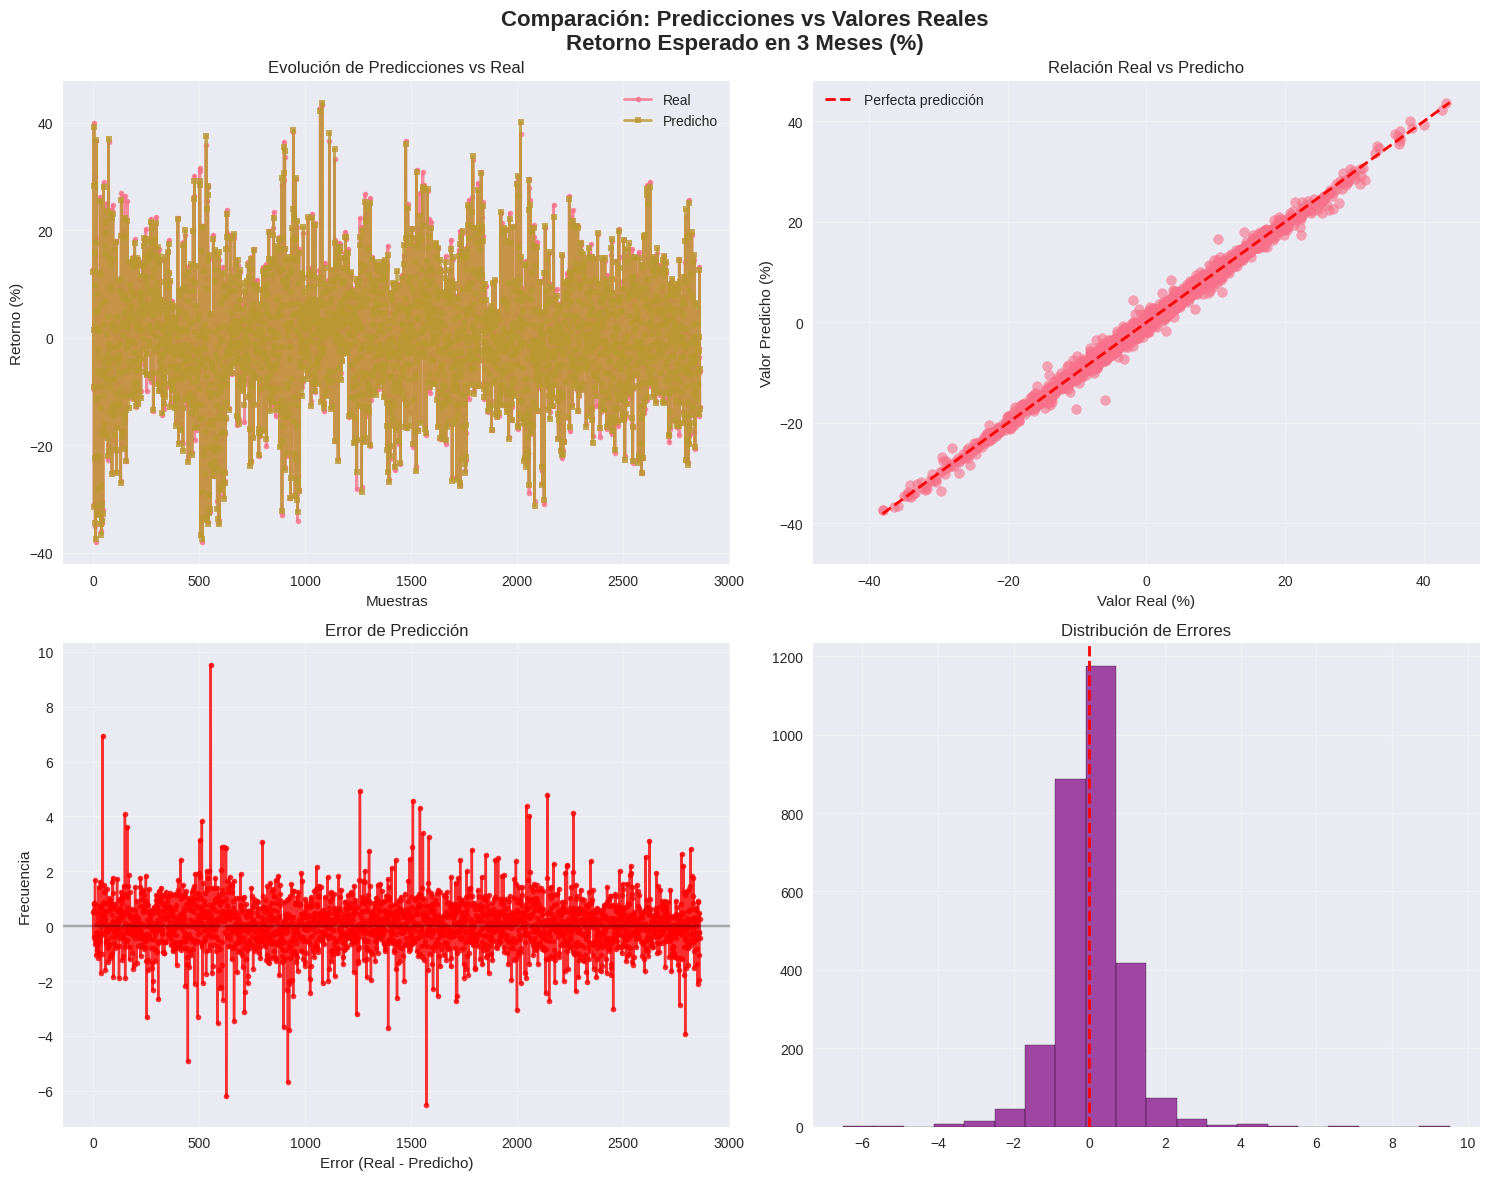

In [303]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Configurar estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Crear figura
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Comparación: Predicciones vs Valores Reales\nRetorno Esperado en 3 Meses (%)',
             fontsize=16, fontweight='bold')

# 1. Gráfico de líneas comparativo
axes[0, 0].plot(actual, label='Real', marker='o', markersize=4, linewidth=2, alpha=0.8)
axes[0, 0].plot(predicted, label='Predicho', marker='s', markersize=4, linewidth=2, alpha=0.8)
axes[0, 0].set_xlabel('Muestras')
axes[0, 0].set_ylabel('Retorno (%)')
axes[0, 0].set_title('Evolución de Predicciones vs Real')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Scatter plot con línea de perfecta predicción
max_val = max(max(predicted), max(actual))
min_val = min(min(predicted), min(actual))
limit = max(abs(max_val), abs(min_val)) * 1.1

axes[0, 1].scatter(actual, predicted, alpha=0.6, s=50)
axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfecta predicción')
axes[0, 1].set_xlabel('Valor Real (%)')
axes[0, 1].set_ylabel('Valor Predicho (%)')
axes[0, 1].set_title('Relación Real vs Predicho')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlim(-limit, limit)
axes[0, 1].set_ylim(-limit, limit)

# 3. Gráfico de error (diferencia)
error = np.array(actual) - np.array(predicted)
axes[1, 0].plot(error, marker='o', markersize=4, color='red', alpha=0.8)
axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[1, 0].set_xlabel('Muestras')
axes[1, 0].set_ylabel('Error (Real - Predicho)')
axes[1, 0].set_title('Error de Predicción')
axes[1, 0].grid(True, alpha=0.3)

# 4. Histograma de errores
axes[1, 1].hist(error, bins=20, alpha=0.7, color='purple', edgecolor='black')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Error (Real - Predicho)')
axes[1, 0].set_ylabel('Frecuencia')
axes[1, 1].set_title('Distribución de Errores')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()